# Use AutoAI and AI lifecycle to predict credit risk with `ibm-watsonx-ai`

This notebook contains the steps and code to demonstrate support of AI Lifecycle features of am AutoAI model in Watson Machine Learning Service in Watson Machine Learning service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository. It also introduces commands for  training, persisting and deploying model, scoring it, updating the model and redeploying it.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiments to train AutoAI models.
-  Persist an external model in Watson Machine Learning repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.
-  Update previously persisted model.
-  Redeploy model in-place.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Experiment Run](#run)
4. [Persist and Deploy trained AutoAI model](#persistence)
5. [Refine and persist new version of the model](#refine)
6. [Redeploy and score new version of the model](#redeploy)
7. [Clean up](#cleanup)
8. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, contact with your Cloud Pack for Data administrator and ask for your account credentials.

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U lale | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U scikit-learn==1.3.0 | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [ ]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.1"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.1"
)

```

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [3]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to training data CSV file. This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/data/credit_risk/credit_risk_training_light.csv).

In [5]:
filename = 'credit_risk_training_light.csv'

Download training data from git repository.

In [ ]:
import os, wget

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd5.1/data/credit_risk/credit_risk_training_light.csv'
if not os.path.isfile(filename): wget.download(url)

In [9]:
asset_details = client.data_assets.create('credit_risk_training', filename)
asset_details

Creating data asset...
SUCCESS


{'metadata': {'space_id': '8eaa4f99-9243-4226-95bf-fdafc64b91e3',
  'usage': {'last_updated_at': '2024-05-08T14:12:26Z',
   'last_updater_id': '1000330999',
   'last_update_time': 1715177546138,
   'last_accessed_at': '2024-05-08T14:12:26Z',
   'last_access_time': 1715177546138,
   'last_accessor_id': '1000330999',
   'access_count': 0},
  'rov': {'mode': 0,
   'collaborator_ids': {},
   'member_roles': {'1000330999': {'user_iam_id': '1000330999',
     'roles': ['OWNER']}}},
  'name': 'credit_risk_training',
  'description': '',
  'asset_type': 'data_asset',
  'origin_country': 'us',
  'resource_key': 'credit_risk_training',
  'rating': 0.0,
  'total_ratings': 0,
  'catalog_id': 'e2327764-71a8-4813-bd78-e705563a347f',
  'created': 1715177546138,
  'created_at': '2024-05-08T14:12:26Z',
  'owner_id': '1000330999',
  'size': 0,
  'version': 2.0,
  'asset_state': 'available',
  'asset_attributes': ['data_asset'],
  'asset_id': '16fa020a-bfd5-4cf3-9033-5db05e29e744',
  'asset_category': 'US

In [10]:
from ibm_watsonx_ai.helpers import DataConnection, AssetLocation


credit_risk_conn = DataConnection(
    location=AssetLocation(asset_id=client.data_assets.get_id(asset_details)))

training_data_reference=[credit_risk_conn]

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [11]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
)

Configuration parameters can be retrieved via `get_params()`.

In [12]:
pipeline_optimizer.get_params()

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': '',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'roc_auc',
 'holdout_size': None,
 'max_num_daub_ensembles': None,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'include_batched_ensemble_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'csv_separator': ',',
 'excel_sheet': None,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'outliers_columns': None,
 'text_processing': None,
 'word2vec_feature_number': None,
 'daub_give_priority_to_runtime': None,
 'text_columns_names': None,
 'sampling_type': None,
 'sample_size_limit': None,
 'sample_rows_limit': None,
 'sample_percentage_limit': None,
 'number_of_batch_rows': None,
 'n_parallel_data_connections': None,
 'test_

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [ ]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [14]:
pipeline_optimizer.get_run_status()

'completed'

#### Load trained model

In [ ]:
pipeline = pipeline_optimizer.get_pipeline()

#### Reading training data from COS

In [ ]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

<a id="persistence"></a>
## 4. Persist and Deploy trained AutoAI model

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

### Online deployment creation

In [11]:
from ibm_watsonx_ai.deployment import WebService

service = WebService(credentials, source_space_id=space_id)

service.create(
    experiment_run_id=run_details["metadata"]["id"],
    model="Pipeline_1", 
    deployment_name="AutoAI credit-risk deployment")

Preparing an AutoAI Deployment...
Published model uid: 44472067-33d4-4708-9dd2-d305c0eca40f
Deploying model 44472067-33d4-4708-9dd2-d305c0eca40f using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '44472067-33d4-4708-9dd2-d305c0eca40f' started

#######################################################################################


initializing....
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='0a561646-ce6e-4dd4-96c4-488463417307'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [ ]:
print(service)

To show all available information about the deployment use the `.get_params()` method:

In [ ]:
service.get_params()

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [14]:
predictions = service.score(payload=train_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.9937857257272232, 0.006214274272776733]],
    ['No Risk', [0.9692945258787946, 0.030705474121205386]],
    ['No Risk', [0.9659028536178904, 0.034097146382109624]],
    ['No Risk', [0.9528451816827154, 0.0471548183172846]],
    ['Risk', [0.040341752701822275, 0.9596582472981777]],
    ['Risk', [0.05804472513532977, 0.9419552748646702]],
    ['No Risk', [0.8992536806845922, 0.10074631931540776]],
    ['No Risk', [0.8997752272794306, 0.1002247727205694]],
    ['No Risk', [0.998303342620675, 0.0016966573793250517]],
    ['Risk', [0.007805452098065269, 0.9921945479019347]]]}]}

If you want to work with the web service in an external Python application you can retrieve the service object by:
 - Initialize the service by `service = WebService(wml_credentials)`
 - Get deployment_id by `service.list()` method
 - Get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete the existing deployment by calling the `service.delete()` command.
To list the existing web services you can use `service.list()`.

<a id="refine"></a>
## 5. Refine and persist new version of the model

In this section, you'll learn how to store new refinement version of your model in Watson Machine Learning repository by using the Watson Machine Learning Client.

### Pipeline refinement with [Lale](https://github.com/IBM/lale)

In this section you learn how to refine and retrain the best
pipeline returned by AutoAI. There are many ways to refine a pipeline.
For illustration, simply replace the final estimator in the
pipeline by an interpretable model. The call to
`wrap_imported_operators()` augments scikit-learn operators with
schemas for hyperparameter tuning.

In [15]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale import wrap_imported_operators

wrap_imported_operators()

#### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

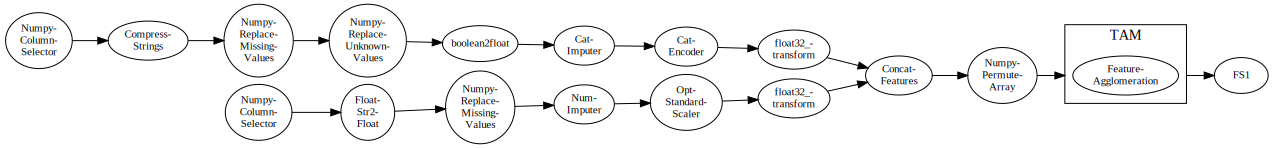

In [16]:
prefix = pipeline.remove_last().freeze_trainable()
prefix.visualize()

Next, add a new final step, which consists of a choice of three
estimators. In this code, `|` is the or combinator (algorithmic
choice). It defines a search space for another optimizer run.

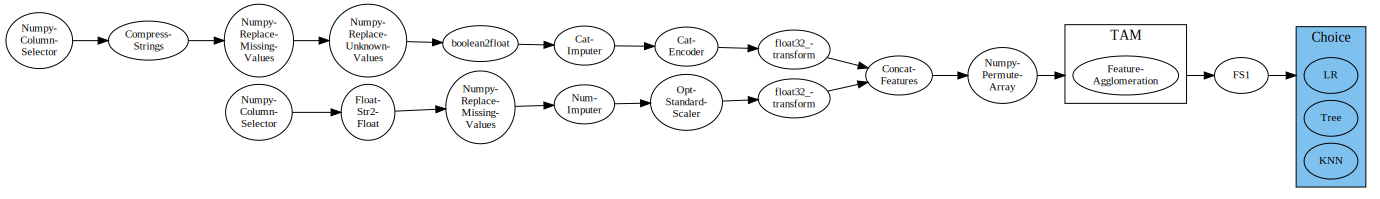

In [17]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

#### New optimizer `Hyperopt` configuration and training

To automatically select the algorithm and tune its hyperparameters, we
create an instance of the `Hyperopt` optimizer and `fit` it to the
data.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.15, random_state=33)

In [19]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='roc_auc')
hyperopt_pipelines = hyperopt.fit(X_train, y_train)

100%|██████████| 20/20 [00:36<00:00,  1.82s/trial, best loss: -0.7943909200702679]


In [20]:
pipeline_model = hyperopt_pipelines.get_pipeline(astype='sklearn')

#### Save newly refined pipeline

In [21]:
import joblib

model_path = "refined_pipeline.pickle"
joblib.dump(pipeline_model, model_path);

In [22]:
import tarfile

with tarfile.open(model_path + ".tar.gz", "w:gz") as tar:
    tar.add(model_path)
model_path += ".tar.gz"

### Publish new version of the model

#### Download current version of the model

In [23]:
model_id = service.get_params()['entity']['asset']['id']
deployment_id = service.get_params()['metadata']['id']

In [25]:
downloaded_model_name = "current_model.zip"
client.repository.download(model_id, downloaded_model_name);

Successfully saved model content to file: 'current_model.zip'


In [26]:
import zipfile

with zipfile.ZipFile(downloaded_model_name, "r") as zip_ref:
    zip_ref.extractall()

#### Create archive containing updated model

In [27]:
updated_model_path = "updated_model.zip"
with zipfile.ZipFile(updated_model_path, "w") as zip_ref:
    zip_ref.write(model_path)
    zip_ref.write("pipeline-model.json")

#### Save the current model version

In [ ]:
import json

print(json.dumps(client.repository.create_model_revision(model_id), indent=2))

#### Update the model

In [29]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'AutoAI credit-risk updated model'
}

published_model = client.repository.update_model(
    model_id=model_id,
    update_model=updated_model_path,
    updated_meta_props=metadata
)

#### Save new model revision of the updated model

In [ ]:
new_model_revision = client.repository.create_model_revision(model_id)
print(json.dumps(new_model_revision, indent=2))

**Note:** Model revisions can be identified by model `id` and `rev` number. 

Get model `rev` number from creation details:

In [31]:
rev_id = new_model_revision['metadata'].get('rev')

#### List list existing revisions of the model

In [32]:
client.repository.list_models_revisions(model_id)

--  --------------------------------  ------------------------
ID  NAME                              CREATED
2   AutoAI credit-risk updated model  2021-10-18T14:42:08.102Z
1   P1                                2021-10-18T14:42:08.102Z
--  --------------------------------  ------------------------


#### Get details of updated model

In [ ]:
print(json.dumps(client.repository.get_details(model_id), indent=2))

<a id="redeploy"></a>
## 6. Redeploy and score new version of the model

In this section, you'll learn how to redeploy new version of the model by using the watsonx.ai Client.

In [34]:
metadata = {
    client.deployments.ConfigurationMetaNames.ASSET: {
        "id": model_id,
        "rev": rev_id
    }
}
    
updated_deployment = client.deployments.update(deployment_id, changes=metadata)

Since ASSET is patched, deployment with new asset id/rev is being started. Monitor the status using deployments.get_details(deployment_uid) api


Wait for the deployment update: 

In [35]:
import time

status = None
while status not in ['ready', 'failed']:
    print('.', end=' ')
    time.sleep(2)
    deployment_details = client.deployments.get_details(deployment_id)
    status = deployment_details['entity']['status'].get('state')
    
print("\nDeployment update finished with status: ", status)

. . . . . . . . 
Deployment update finished with status:  ready


#### Get updated deployment details

In [ ]:
print(json.dumps(client.deployments.get_details(deployment_id), indent=2))

### Score updated model

In [37]:
scoring_payload = {"input_data": [{"values": train_df.drop(['Risk'], axis=1).iloc[:5]}]}

Use client.deployments.score() method to run scoring.

In [38]:
predictions = client.deployments.score(deployment_id, scoring_payload)

In [39]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "fields": [
        "prediction",
        "probability"
      ],
      "values": [
        [
          "No Risk",
          [
            0.9807692307692307,
            0.019230769230769232
          ]
        ],
        [
          "No Risk",
          [
            0.9807692307692307,
            0.019230769230769232
          ]
        ],
        [
          "No Risk",
          [
            0.847457627118644,
            0.15254237288135594
          ]
        ],
        [
          "No Risk",
          [
            0.847457627118644,
            0.15254237288135594
          ]
        ],
        [
          "Risk",
          [
            0.29508196721311475,
            0.7049180327868853
          ]
        ]
      ]
    }
  ]
}


<a id="cleanup"></a>
## 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

You successfully completed this notebook!  

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Jan Sołtysik**, Intern 

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.